# Статистика, прикладной поток
## Практическое задание 6

В данном задании вы исследуете некоторые свойства непараметрических методов, а также проверки статистических гипотез.

**Правила:**

* Дедлайн **2 декабря 23:59**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить на почту ` mipt.stats@yandex.ru`, указав тему письма `"[applied] Фамилия Имя - задание 6"`. Квадратные скобки обязательны. Если письмо дошло, придет ответ от автоответчика.
* Прислать нужно ноутбук и его pdf-версию (без архивов). Названия файлов должны быть такими: `6.N.ipynb` и `6.N.pdf`, где `N` - ваш номер из таблицы с оценками.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 -  2 балла **O3**
* Задача 2 -  10 баллов **O2**
* Задача 3 -  5 баллов **O3**
* Задача 4 -  5 баллов **O3**
* Задача 5 -  5 баллов **O3**
* Задача 6 -  12 баллов **O3**
* Задача 7 -  20 баллов **O3**
* Задача 8 -  15 баллов **O3**

In [2]:
import numpy as np
import scipy.stats as sps
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.nonparametric.kde import kernel_switch, KDEUnivariate
from statsmodels.distributions.empirical_distribution import ECDF

from datetime import datetime 
 
%matplotlib inline

## Непараметрический подход

__________________
### Задача 1.

Напишите определение ядра, используемого для построения ядерных оценок плотности.

* Ядро $q$, используемое для построения ядерных оценок плотности - это некоторая симметричная плотность. 

Прежде чем начать работу с ядерными оценками плотности, изучим виды ядер. В библиотеке `statsmodels` реализованы следующие ядра:

In [2]:
list(kernel_switch.keys())

['gau', 'epa', 'uni', 'tri', 'biw', 'triw', 'cos', 'cos2']

Нарисуем эти ядра. Запустите код в ячейке.

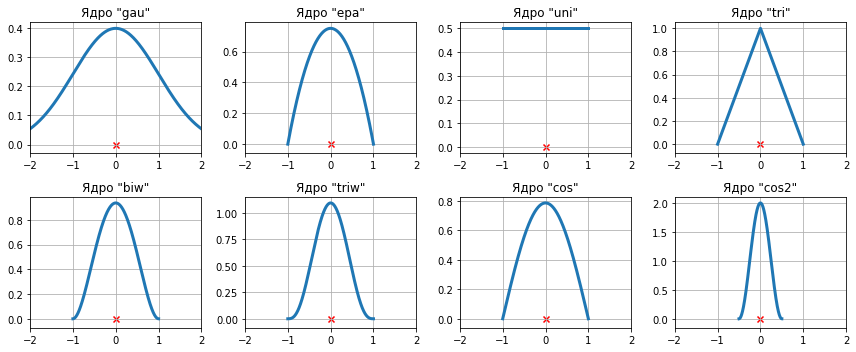

In [3]:
fig = plt.figure(figsize=(12, 5))

for i, (ker_name, ker_class) in enumerate(kernel_switch.items()):
    
    kernel = ker_class()  # ядро
    domain = kernel.domain or [-2, 2]  # носитель
    x_vals = np.linspace(*domain, 2**10)
    y_vals = kernel(x_vals)

    ax = fig.add_subplot(2, 4, i + 1)
    ax.set_title('Ядро "{}"'.format(ker_name))
    ax.plot(x_vals, y_vals, lw=3, label='{}'.format(ker_name))
    ax.scatter([0], [0], marker='x', color='red')
    plt.grid(True, zorder=-5)
    ax.set_xlim((-2, 2))
    
plt.tight_layout()

Посморим, как будет выглядеть ядерная оценка плотности в зависимости от типа ядра, взяв в качестве реализации выборки набор точек [-1, 0, 1]. Запустите код в ячейке.

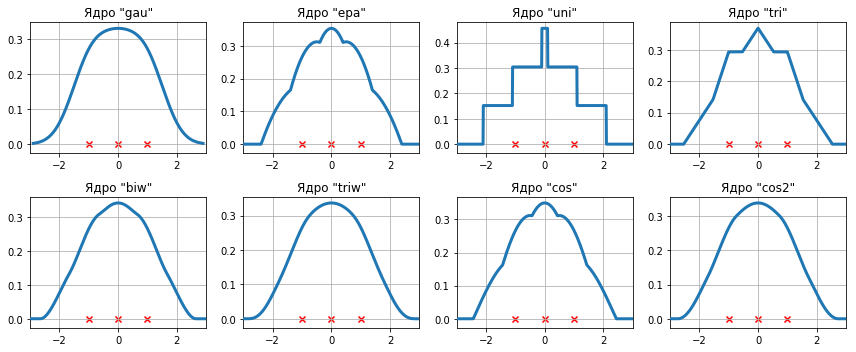

In [4]:
data = np.linspace(-1, 1, 3)  # выборка
kde = KDEUnivariate(data)  # объект, выполняющий построение оценки

fig = plt.figure(figsize=(12, 5))

for i, kernel in enumerate(kernel_switch.keys()):
    
    ax = fig.add_subplot(2, 4, i + 1)
    ax.set_title('Ядро "{}"'.format(kernel))
    
    # построение ядерной оценки плотности с заданным ядром
    kde.fit(kernel=kernel, fft=False, gridsize=2**10)
    # отрисовка полученной оценки
    ax.plot(kde.support, kde.density, lw=3, zorder=10)
    # отрисовка выборки
    ax.scatter(data, np.zeros_like(data), marker='x', color='red')
    plt.grid(True, zorder=-5)
    ax.set_xlim([-3, 3])
    
 

Какие вы можете назвать преимущества и недостатки для первых трех ядер как с точки зрения самой оценки плотности, так и с вычислительной точки зрения?

Мы видим, что первое ядро - то есть гауссовское - хорошо приближает наши три точким - отличается на графике  гладкостью, видно что кривая не претерпевает резкие скачки при переходе от одной точки выборки до другой -  действительно по виду похоже на некоторую плотность распределения. А, например, ядро Епаненчикова уже гораздо существенней реагирует на отдельные точки выборки. У прямоугольного ядра kde вообще разрывная, хорошо видно, что претерпевает резкие скачки при переходе от одного элемента выборки до другого.

Что касается вычисления этих функций, то понятно, что вычисление прямоугольной kde - легче вычислить чем остальные два. Затем по степени сложности вычисления стоит ядро Епаненчикова (квадратичная функция), а сложнее всего вычислять Гауссовское, так там экспонента.

Другие примеры работы с ядерными оценками плотности можно посмотреть по ссылке http://www.statsmodels.org/dev/examples/notebooks/generated/kernel_density.html

__________________
### Задача 2.

**1.** Сгенерируйте выборку $X_1, ..., X_{10000}$ из стандартного нормального распределения. Для каждого $n \leqslant 10000$ постройте эмпирическую функцию распределения $\widehat{F}_n$ и посчитайте **точное** значение статистики $$D_n = \sup\limits_{x \in \mathbb{R}} \left| \widehat{F}_n(x) - F(x) \right|.$$

Постройте график зависимости статистики $D_n$ от $n$. Верно ли, что $D_n \to 0$ и в каком смысле? 

Для выполнения задания можно использовать следующую функцию:

In [5]:
from statsmodels.distributions.empirical_distribution import ECDF
help(ECDF)  # В случае затруднений раскомментировать и выполнить

Help on class ECDF in module statsmodels.distributions.empirical_distribution:

class ECDF(StepFunction)
 |  Return the Empirical CDF of an array as a step function.
 |  
 |  Parameters
 |  ----------
 |  x : array-like
 |      Observations
 |  side : {'left', 'right'}, optional
 |      Default is 'right'. Defines the shape of the intervals constituting the
 |      steps. 'right' correspond to [a, b) intervals and 'left' to (a, b].
 |  
 |  Returns
 |  -------
 |  Empirical CDF as a step function.
 |  
 |  Examples
 |  --------
 |  >>> import numpy as np
 |  >>> from statsmodels.distributions.empirical_distribution import ECDF
 |  >>>
 |  >>> ecdf = ECDF([3, 3, 1, 4])
 |  >>>
 |  >>> ecdf([3, 55, 0.5, 1.5])
 |  array([ 0.75,  1.  ,  0.  ,  0.25])
 |  
 |  Method resolution order:
 |      ECDF
 |      StepFunction
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, x, side='right')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 | 

In [2]:
# получаю выборку из нормального
sample = sps.norm().rvs(10000)
cdfs  = sps.norm().cdf(sample)
ones = np.ones(len(sample))

# значения cdf на выборке sample, продублированные
# на квадратичную матрицу
cdfs =  np.einsum("i, j-> ij", ones, cdfs)

In [3]:
cdfs = np.tril(cdfs) + \
np.triu(np.ones((len(sample), len(sample))), k=1)

In [4]:
cdfs = np.sort(cdfs)

In [5]:
grid = np.arange(1, len(sample) + 1)

# в нижнем треугольнике значения эмпирической cdf - 
#в точках sample[:i], 1<=i<=n
# i-aя строка - значения на i-ом префиксе
ecdfs = np.einsum("i,j->ij", 1/grid, grid)

In [6]:
# сама D_k
Ds = np.max(np.abs(np.tril(cdfs - ecdfs)), axis=1)

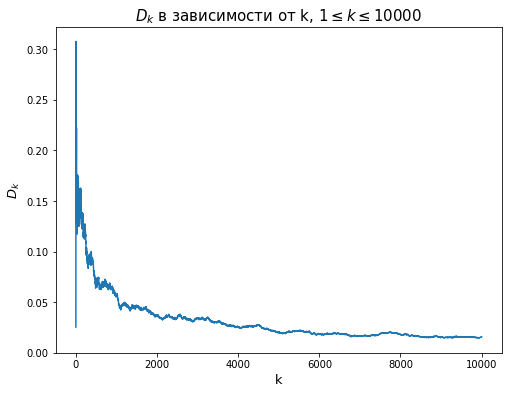

In [7]:
plt.figure(figsize=(8,6))

plt.title(r"$D_k$ в зависимости от k, $1 \leq k \leq 10000$",
         fontsize=15)

plt.plot(grid, Ds)

plt.xlabel("k", fontsize=13)
plt.ylabel(r"$D_k$", fontsize=13)

plt.show()

**Вывод:**

Действительно мы можем видеть, что последовательность $D_n \to 0$ при $n \to +\infty$, причем сходимость к нулю довольно равномерная. Это подтверждает теорему Гливенко-Кантелли о сходимости $D_n$ к нулю. То есть мы можем сказать, что эмперическая функция распределения действительно хорошо описывает приближает инстинную.

**2.** Для $n = 10000$ и $k = 10000$ (значение $k$ можно взять больше) выполните следующее:
    
Вычислите $D_n^1, ... , D_n^k$ для независимых выборок $(X_1^1, ... , X_n^1)$, ... ,$(X_1^k, ... , X_n^k)$ из стандартного нормального распределения. Постройте график гистограммы значений $\sqrt{n} D_n^1, ... , \sqrt{n} D_n^k$ и ядерной оценки плотности распределения этих величин.

Для выполнения задания можно воспользоваться как функцией `seaborn.distplot` (желательно), так и реализацией в `statsmodels`.

In [3]:
def DX2(sample):
    ones = np.ones(len(sample))
    grid = np.arange(1, len(sample) + 1)
    ecdfs = np.einsum("i,j->ij", ones, 1/grid[::-1])
    cdfs = np.sort(sps.norm().cdf(sample), axis=1)
    
    return np.max(np.abs(ecdfs - cdfs), axis=1)


sample = sps.norm().rvs(size = (10000, 10000))


# DD = DX2(sample)

In [6]:
ones = np.ones(len(sample))
grid = np.arange(1, len(sample) + 1)

In [16]:
ecdfs = np.einsum("i,j->ij", ones, grid/10000)

In [4]:
cdfs = sps.norm().cdf(sample)

In [5]:
cdfs = np.sort(cdfs, axis=1)

In [17]:
DD = np.max(np.abs(ecdfs - cdfs), axis=1)

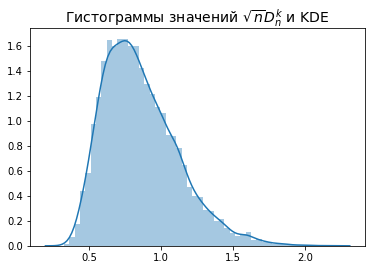

In [30]:
ax = sns.distplot(100*DD)


ax.set_title(r"Гистограммы значений $\sqrt{n}D_n^k$ и KDE",
            fontsize=14)

plt.show()

**Вывод:**

Как показывает график, мы можем наблюдать что $\sqrt{n}D_n$ - похоже на конкретное распределение - а именно на распределение Колмогорова. Это подтверждает теорему Колмогорова-Смирнова о сходимости $\sqrt{n}D_n$ по распределению к случайной величине из распределения Колмогорова.

__________________
### Задача 3.
Для каждого распределения постройте график эмпирической функции распределения, гистограмму и график ядерной оценки плотности. 

Вам выдется почти готовый код для выполнения задания с некоторыми пропусками. Код предполагает использование реализации ядерных оценок плотности из `statsmodels`. При желании вы можете написать аналогичный код, используя реализацию в `seaborn`.

In [7]:
def draw_ecdf(sample, grid, cdf=None):
    """По сетке grid cтроит графики эмпирической функции распределения 
    и истинной (если она задана) для всей выборки и для 1/10 ее части.
    """
    plt.figure(figsize=(16, 3))
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        plt.scatter(sample[:size], np.zeros(size),
                    alpha=0.4, label='sample')
        
        if cdf is not None:
            plt.plot(grid,
                     cdf(grid),
                     color='green', alpha=0.3, lw=2, label='true cdf')
        
        plt.plot(grid,
                 ECDF(sample[:size])(grid),
                 color='red', label='ecdf')
        
        plt.legend()
        plt.grid(ls=':')
        plt.title('sample size = {}'.format(size))
    plt.show()

In [12]:
def draw_hist(sample, grid, pdf=None):
    """Строит гистограмму и, по сетке grid, график истинной плотности 
    (если она задана) для всей выборки и для 1/10 ее части.
    """
    plt.figure(figsize=(16, 3))
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        plt.hist(sample[:size],
                 bins=20,
                 range=(grid.min(), grid.max()),
                 density=True, label='sample hist')
        
        if pdf is not None :
            plt.plot(grid,
                     pdf(grid),
                     color='green', alpha=0.3, lw=2, label='true pdf')
        
        plt.legend()
    plt.show()

In [21]:
def draw_pdf(sample, grid, pdf=None):
    """По сетке grid cтроит графики ядерной оценки плотности 
    и истинной плотности (если она задана) для всей выборки
    и для 1/10 ее части.
    """
    plt.figure(figsize=(16, 3))
    for i, size in enumerate([len(sample) // 10, len(sample)]):
        plt.subplot(1, 2, i + 1)
        
        plt.scatter(sample[:size], np.zeros(size),
                    alpha=0.4, label='sample')
        
        if pdf is not None:
            plt.plot(grid,
                     pdf(grid), color='green', 
                     alpha=0.3, lw=2, label='true pdf')
        
        kde = KDEUnivariate(sample[:size])
        kde.fit(kernel='gau')
        plt.plot(grid,
                 kde.evaluate(grid),
                 color='red', label='kde')
        
        plt.legend()
        plt.grid(ls=':')
    plt.show()

Теперь примените реализованные выше функции к выборкам размера 500 для следующих распределений:

*1. Равномерное распределение $U[0,1]$*. Графики (ф.р., плотностей) строить на интервале $(-0.2, 1.2)$.

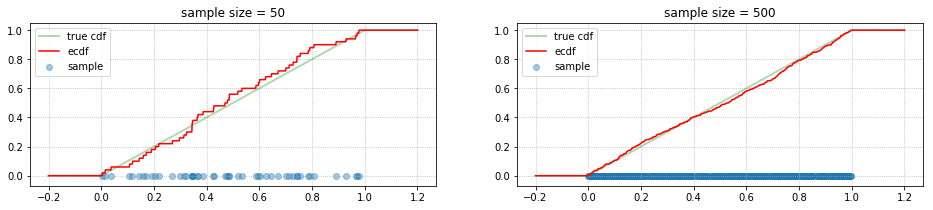

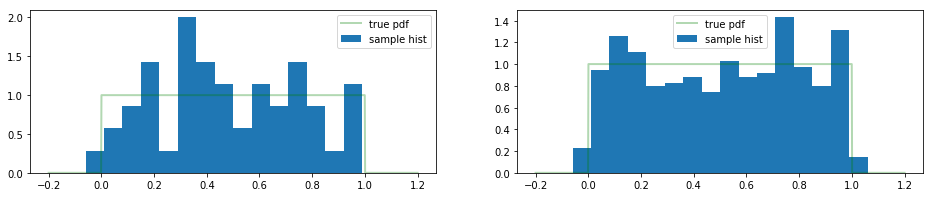

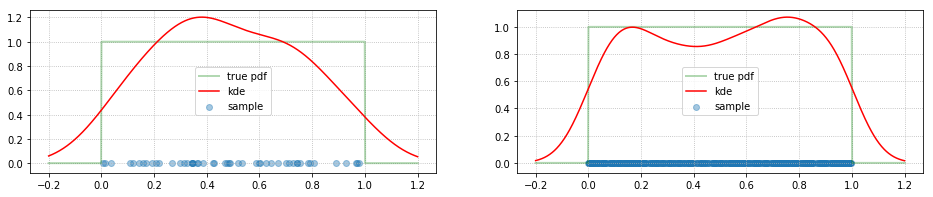

In [22]:
n = 500
sample = sps.uniform().rvs(500)
grid = np.linspace(-0.2, 1.2, 1000)

draw_ecdf(sample, grid, sps.uniform().cdf)

draw_hist(sample, grid, sps.uniform().pdf)

draw_pdf(sample, grid, sps.uniform().pdf)

*2. Нормальное распределение $\mathcal{N}(0, 1)$.* Графики строить на интервале $(-3, 3)$.

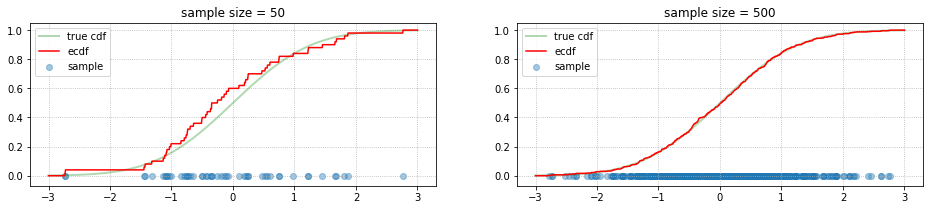

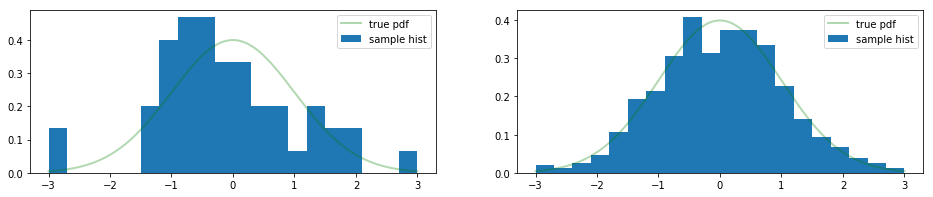

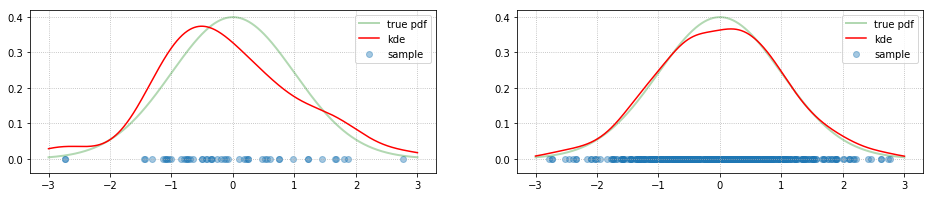

In [14]:
sample = sps.norm().rvs(500)
grid = np.linspace(-3, 3, 1000)

draw_ecdf(sample, grid, sps.norm().cdf)

draw_hist(sample, grid, sps.norm().pdf)

draw_pdf(sample, grid, sps.norm().pdf)

*3. Экспоненциальное распределение $Exp(1)$.* Графики строить на интервале $(-0.5, 5)$.

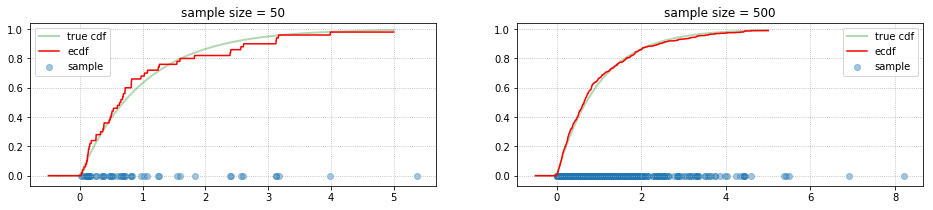

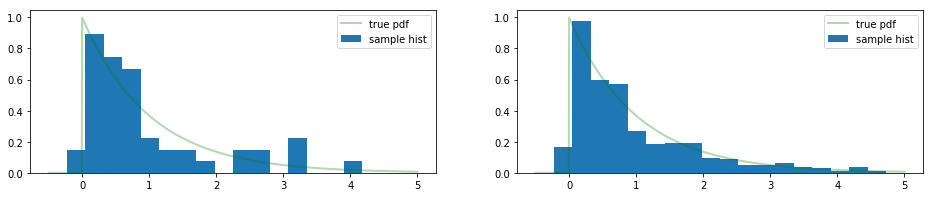

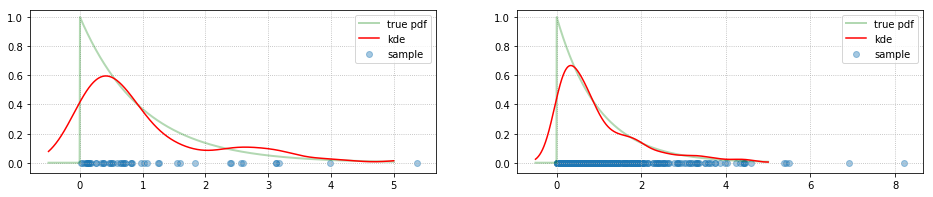

In [16]:
sample = sps.expon().rvs(500)
grid = np.linspace(-0.5, 5, 1000)

draw_ecdf(sample, grid, sps.expon().cdf)

draw_hist(sample, grid, sps.expon().pdf)

draw_pdf(sample, grid, sps.expon().pdf)

**Вывод:**

Мы видим, что уже на $\frac{1}{10}$ части выборки чаще всего угадывается распределение, но можно заметить, что ядерная оценка плотности на небольшой выборке часто имеет лишние "горбы", так как на этом этапе значение одного элемента выборки имеет большой вес. Но на большой выборке все лишние скачки выравниваются, и оценка плотности все больше становится похожа на истинную.

Если брать гауссовское ядро, то любая оценка плотности получиается довольно гладкой. 
Это наиболее хорошо подходит для плотности нормального распределения, также довольно неплохо оценивается экспотенциальная плотность, хотя она не успевает достать до "гребня" в силу того, что оценка старается все сгладить. Наиболее плохо она оценивает равномерную плотность, опять же потому что старается сгладить края.

__________________
### Задача 4.

Исследуйте вид ядерной оценки плотности в зависимости от вида ядра и его ширины.

Для этого сгенерируйте выборку $X_1, ..., X_{200}$ из распределения $U[0, 1]$ и постройте серию графиков для различной ширины гауссовского ядра, а затем другую серию графиков для различных типов ядер при фиксированной ширине. На каждом графике на отрезке $[-0.2, 1.2]$ должны быть изображены истинная плотность (полупрозрачным цветом) и ее ядерная оценка, а так же с нулевой $y$-координатой должны быть нанесены точки выборки. Для экономии места стройте графики в два столбца.

Вам выдется почти готовый код для выполнения задания с некоторыми пропусками. Код предполагает использование реализации ядерных оценок плотности из `statsmodels`. При желании вы можете написать аналогичный код, используя реализацию в `seaborn`.

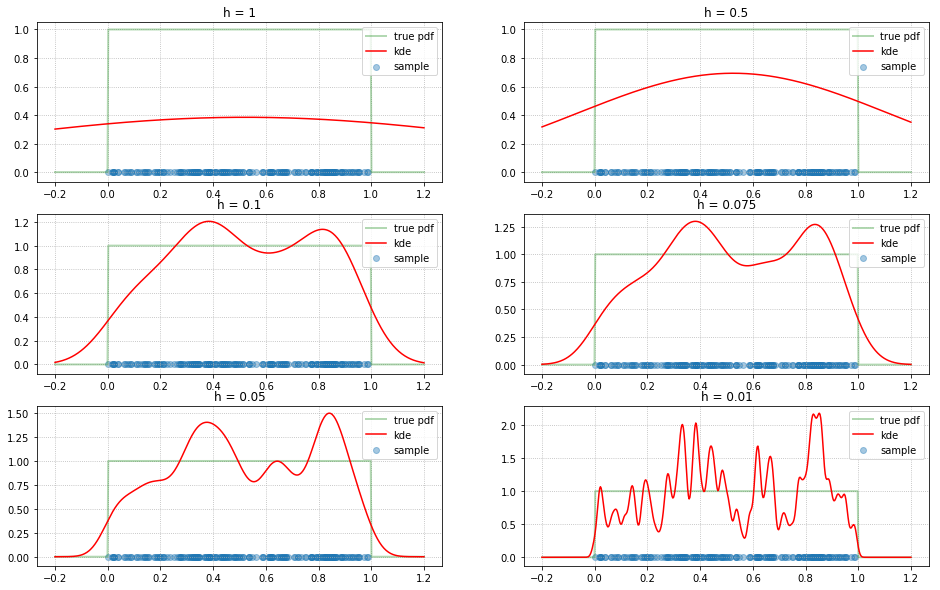

In [23]:
size = 200
sample = sps.uniform().rvs(size)
grid = np.linspace(-0.2, 1.2, 500)

plt.figure(figsize=(16, 10))
for i, bw in enumerate([1, 0.5, 0.1, 0.075, 0.05, 0.01]):
    plt.subplot(3, 2, i + 1)
    kernel_density = KDEUnivariate(sample)
    kernel_density.fit(bw=bw)
    
    plt.scatter(sample, np.zeros(size), alpha=0.4, label='sample')
    plt.plot(grid, sps.uniform.pdf(grid), color='green', 
             alpha=0.3, lw=2, label='true pdf')
    plt.plot(grid, kernel_density.evaluate(grid), 
             color='red', label='kde')
    plt.legend(loc=1)
    plt.grid(ls=':')
    plt.title('h = {}'.format(bw))
plt.show()

Во втором случае графики постройте аналогичным образом, проведя итерации по типу ядра.

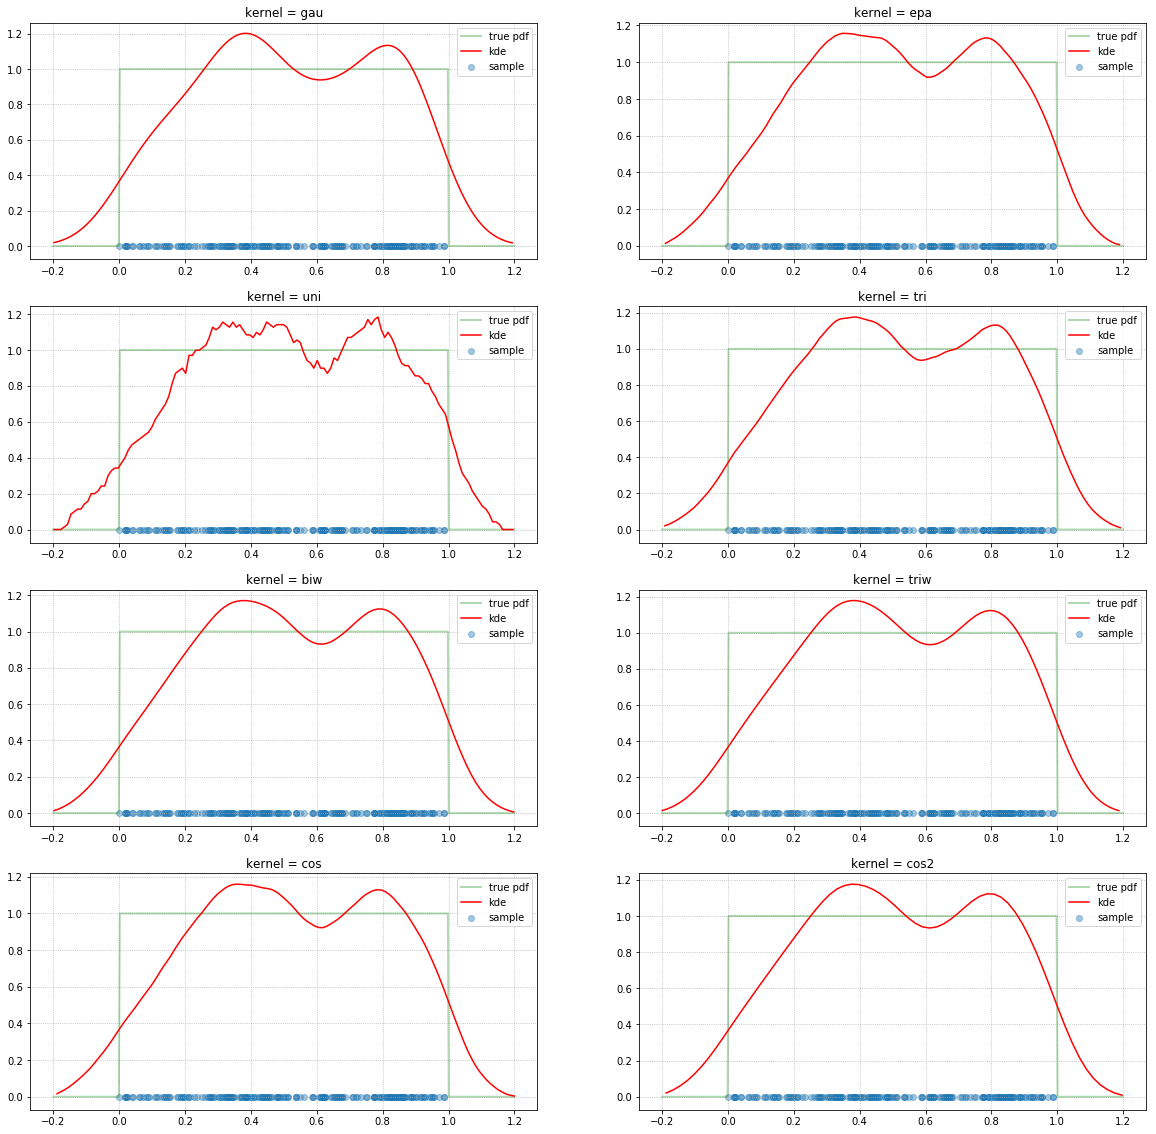

In [52]:
plt.figure(figsize=(20, 20))
for i, kernel in enumerate(kernel_switch.keys()):
    plt.subplot(4, 2, i + 1)
    kernel_density = KDEUnivariate(sample)
    kernel_density.fit(kernel=kernel, fft=False)
    
    plt.scatter(sample, np.zeros(size), alpha=0.4, label='sample')
    plt.plot(grid, sps.uniform.pdf(grid), color='green', 
             alpha=0.3, lw=2, label='true pdf')
    
    support = kernel_density.support   
    k_density = kernel_density.density[np.logical_and(support >= -0.2, support <= 1.2)]
    support = support[np.logical_and(support >= -0.2, support <= 1.2)]

#     print(len(kernel_density.support))
#     print(len(kernel_density.density[np.logical_and(support >= -0.2, support <= 1.2 )]))
    
    
    plt.plot(support, k_density,
             color='red', label='kde')
    plt.legend(loc=1)
    plt.grid(ls=':')
    plt.title('kernel = {}'.format(kernel))
    
plt.show()

**Вывод:**

Все ядра на выборке размером 200 дают очень похожие результаты, разве что равномерное немного отличается, так как оно наименее гладкое среди всех, хотя во основном форма почти одна и та же. 

А вот вариация с h дает различные результаты . При слишком большом значении $h$ - плотность получается слишком гладкой - можно ошибочно подумать, что данные выглядят как единая группа, на всем рассматриваемом отрезке, плотность никак не отражает отдельные скопления в данных. Наоборот, если взять слишком маленькую $h-$ку, то в плотности будут присутствовать слишком много скачков. Поэтому стоит вдумчиво подходить к выбору $h$

__________________
### Задача 5.

Cкачайте данные <a href="http://archive.ics.uci.edu/ml/datasets/wine">`wine dataset`</a> и выберите произвольные 7 столбцов с действительными числами. С помощью `seaborn.PairGrid` постройте таблицу графиков, состоящую из 
* одномерных ядерных оценок плотности по диагонали;
* двумерных ядерных оценок плотности ниже диагонали;
* scatter-plot выше диагонали (`plt.scatter`).

При возникновении затруднений посмотрите обучающий ноутбук по `seaborn`.

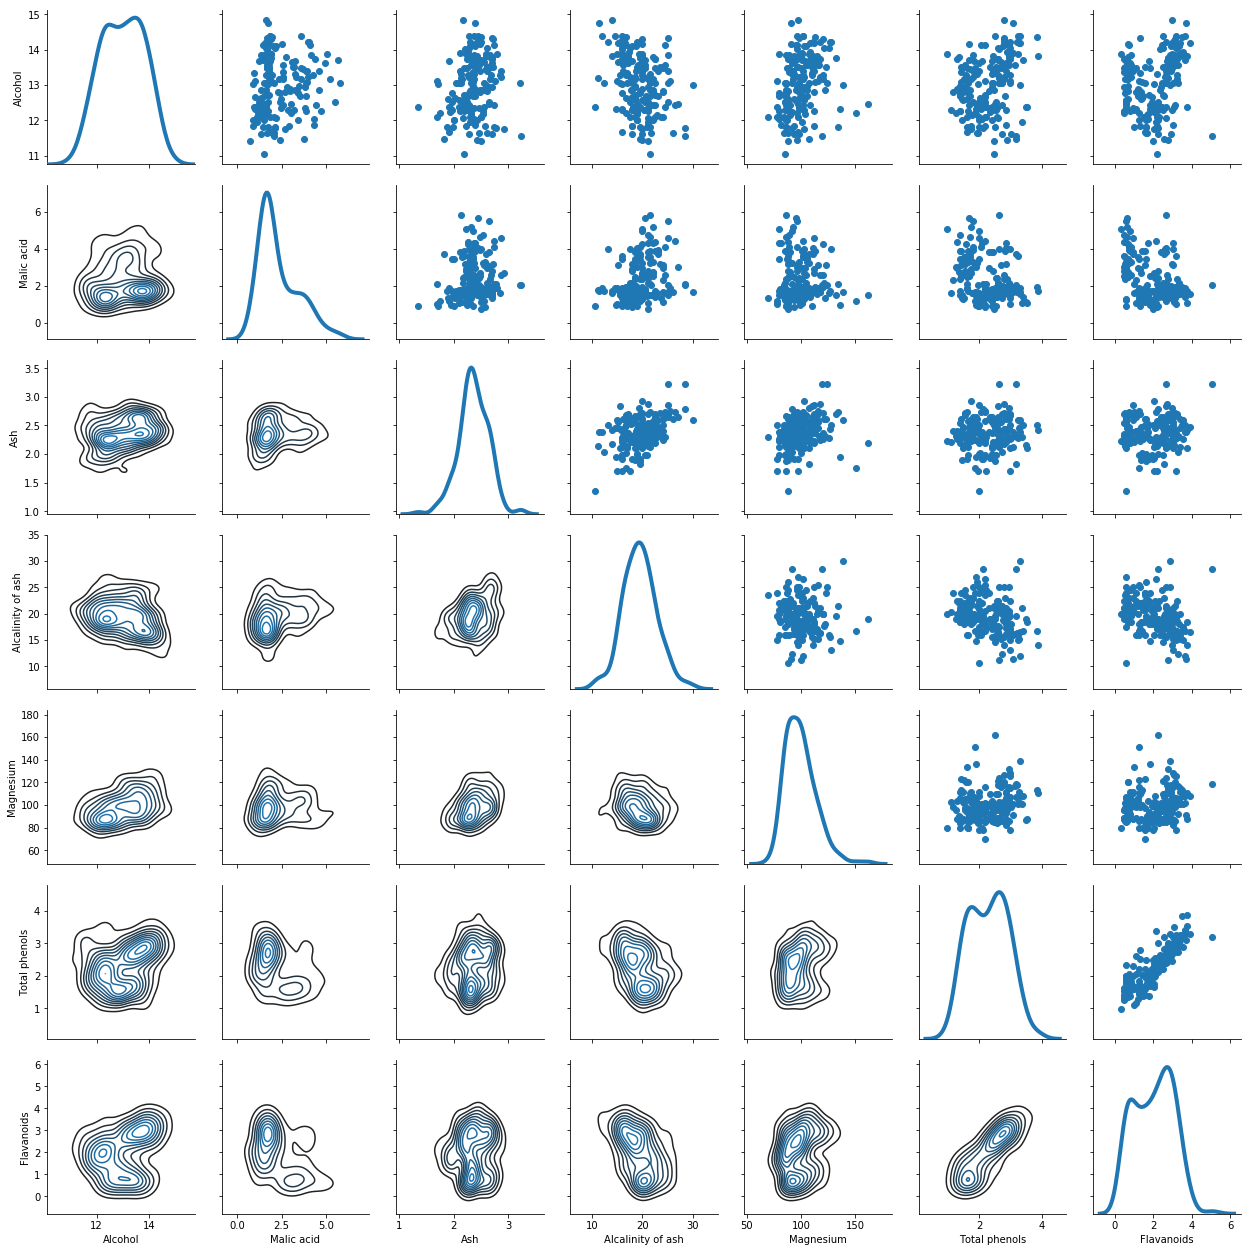

In [5]:
data  = pd.read_csv("wine.data")

columns = ["Alcohol","Malic acid","Ash",
           "Alcalinity of ash","Magnesium",
           "Total phenols","Flavanoids"]

data = data.loc[:,columns]

# sns.set(style="darkgrid")

g = sns.PairGrid(data, diag_sharey=False)

g.map_diag(sns.kdeplot, lw=4)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter)


**Вывод:**

Судя по двумерным ядерным оценкам плотностей в данных - мы можем делать какие-то выводы о зависимости признаков в данных, а также можем судить о выбросах в данных.

Судя по одномерным оценкам плотностей мы можем сказать кое-что о распределении данных. Например, то, что

* Alcohol, Total phenols и Flavanoids - довольно похоже на равномерное распределение
* Ash, Alcanity of Ash - больше смахивает на нормальное
* Malic Acid - похоже на экспотенциальное или даже гамма
* Magnesium - возможно тоже экспотенциальное

__________________
### Задача 6.

Около месяца назад (24-25 октября) в Краснодарском крае сильные ливни привели наводнению, из-за которого сильно пострадали города Сочи и Туапсе. Вам выданы данные об уровне воды за 2014-2018 год по следующим рекам Краснодарского края:
* Мзымта (Сочи, Адлерский район, Роза Хутор)
* Сочи (Сочи, Центральный район)
* Туапсе (Туапсе)
* Херота (Сочи, Адлерский район)
* Хоста (Сочи, Хостинский район)

В файлах используйте столбец `Уровень воды (по БСВ)`. Это уровень воды по <a href="https://ru.wikipedia.org/wiki/Балтийская_система_высот">Балтийской системе высот</a> — принятой в СССР системе нормальных высот, отсчёт которых ведётся от нуля Кронштадтского футштока. Для каждой реки нарисуйте график уровня воды.

Данные собранны за каждые 10 минут, что достаточно тяжело обрабатывать. Преобразуйте данные, рассмотрев максимальное значение уровня воды за сутки.
Вам нужно по данным до октября 2018 года не включительно построить верхнюю границу предсказательного интервала уровня воды и сравнить ее с максимальным значением, достигавшимся в октябре 2018 года. 

Предсказательный интервал постройте в три этапа:
1. Бутстрепный доверительный интервал для среднего значения максимального уровня воды за сутки;
2. Бутстрепный доверительный интервал для стандартного отклонения максимального уровня воды за сутки;
3. Сложите границу доверительного интервала для среднего с границей доверительного интервала для стандартного отклонения, домноженной на 2.

Рассмотрите три способа построения бутстрепных доверительный интервалов, рассказанные на лекции.

Сделайте выводы.

In [197]:
#преоборазование даннных в посуточные
def get_mod_data(name):
    data = pd.read_csv("data/" + name + ".csv", '\t')
    data = data.iloc[:, [0,2]]

    data['Время'] = pd.to_datetime(data['Время'])

    data['День'] = data['Время'].dt.date
    data['Время'] = data['Время'].dt.time
    
    october_begin = datetime.strptime('2018-10-01',
                                      "%Y-%m-%d").date()
    
    october_end = datetime.strptime('2018-10-31',
                                      "%Y-%m-%d").date()
    
    
    past_data = data.where(data['День'] < \
    october_begin).dropna()
    
    october_data = data.where((data['День'] >= \
     october_begin) & (data['День'] <= october_end)).dropna() 
    
    return (past_data.loc[:,['Уровень воды (по БСВ)',
                       'День']].groupby(by='День').max(),
           october_data.loc[:,['Уровень воды (по БСВ)',
                       'День']].groupby(by='День').max())


Sochi, october_sochi = get_mod_data("Сочи")
Tuapse, october_tuapse = get_mod_data("Туапсе")
Herota, october_herota = get_mod_data("Херота")
Hosta, october_hosta = get_mod_data("Хоста")
Msiymta, october_msiymta = get_mod_data("Мзымта")


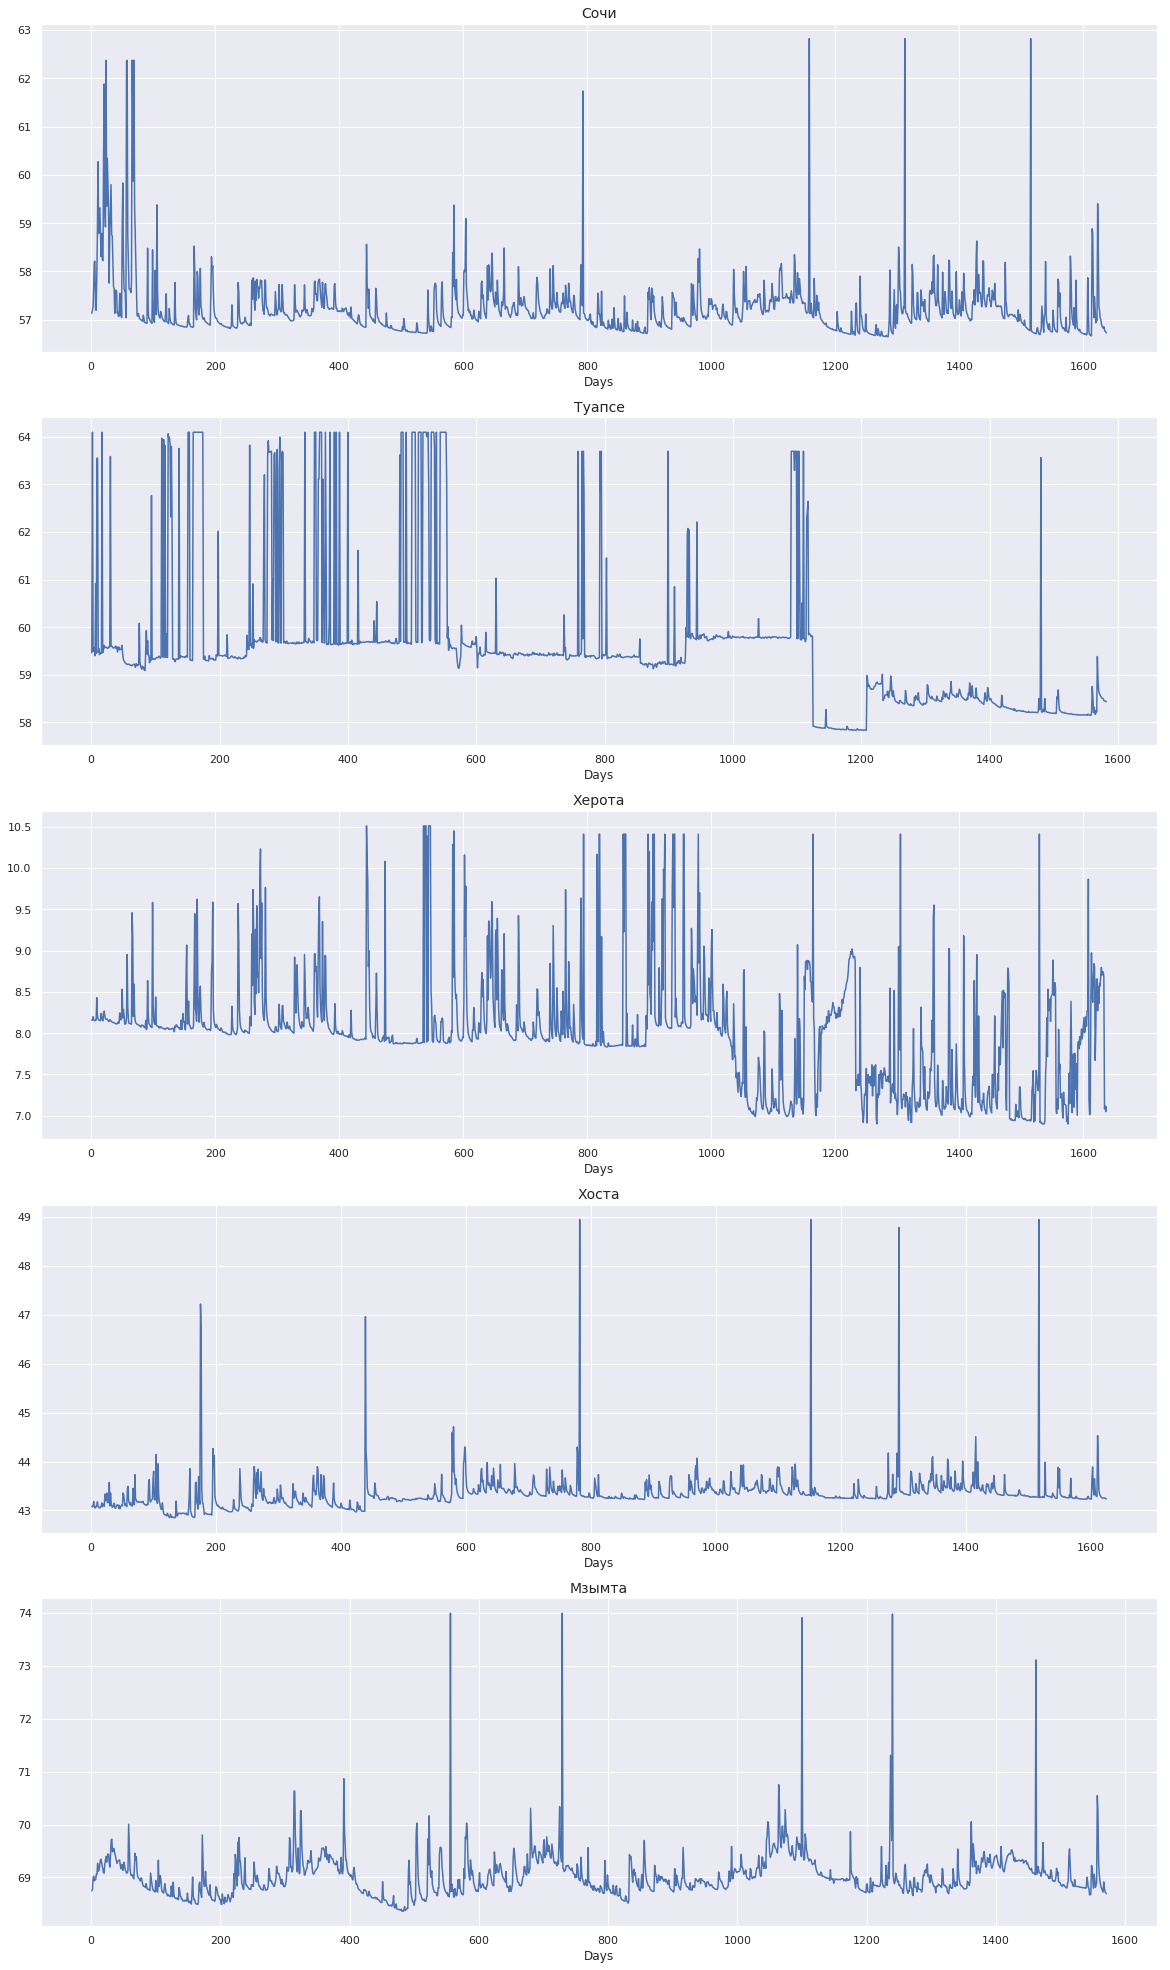

In [198]:
def get_plot(data, name, ind):
    plt.subplot(5,1,ind)
    plt.title(name, fontsize=14)
    grid = np.arange(1, len(data) + 1)
    
    plt.xlabel('Days', fontsize=12)
    
    plt.plot(grid, data['Уровень воды (по БСВ)'], 
             label='Уровень воды (по БСВ)')


plt.figure(figsize=(20,35))

get_plot(Sochi, "Сочи", 1)   
get_plot(Tuapse, "Туапсе", 2)
get_plot(Herota, "Херота", 3)
get_plot(Hosta, "Хоста", 4)
get_plot(Msiymta, "Мзымта", 5)
    

In [199]:
# реализация бутстрепных интервалов

def bootstrap(T, sample, count):
    """ 
    возвращает множество бутстрепных выборок 
    из sample
    в количестве count
    """
    indices = np.random.choice(len(sample), size=(count, len(sample)))
    bootstraps = np.take(sample, indices)
    return T(bootstraps, axis=-1)
    

def norm_interval(T, data, alpha=0.05, count=10000):
    """
    реализует бутстрепный нормальный интервал параметра
    по выборке sample, где статистика T - а.н.о. параметра,
    alpha - уровень доверия
    count - количество бутстрепных выборок
    возвращает  верхнюю границу интервала
    """
    quantile = sps.norm().ppf((1 + alpha)/2)
    
    sample = data['Уровень воды (по БСВ)'].get_values()
    bstraps = bootstrap(T, sample, count)
    boot_var = (bstraps**2).mean() - (bstraps.mean())**2
    return T(sample, axis=0) + quantile*np.sqrt(boot_var)
    
    
def ref_interval(T, data, alpha=0.05, count=10000):
    """
    реализует опорный интервал
    """
    sample = data['Уровень воды (по БСВ)'].get_values()
    bstraps = bootstrap(T, sample, count)

    k = int(np.floor(count*(1 - alpha)/2)) 
    q = np.partition(bstraps, k)[k]

    return 2*T(sample, axis=0) - q


def q_interval(T, data, alpha=0.05, count=10000):
    """
    реализует квантильный интервал
    """
    sample = data['Уровень воды (по БСВ)'].get_values()
    bstraps = bootstrap(T, sample, count)
    
    k = int(np.ceil(count*(1 + alpha)/2) )
    return np.partition(bstraps, k)[k]



In [203]:
datas = [Sochi, Tuapse, Herota, Hosta, Msiymta]
october_datas = [october_sochi, october_tuapse, october_herota, 
                 october_hosta, october_msiymta]
names = ["Сочи", "Туапсе", "Херота", "Хоста", "Мзымта"]

table = list()

for data, october_data, name in zip(datas, october_datas, names):
    norm = norm_interval(np.mean, data) + 2*norm_interval(np.std, data)
    ref = ref_interval(np.mean, data) + 2*ref_interval(np.std, data) 
    quant = q_interval(np.mean, data) + 2*q_interval(np.std, data)
    
    
    raw = (norm, ref, quant, 
           october_data['Уровень воды (по БСВ)'].max())
    table.append(raw)
    
    
result = pd.DataFrame(table, columns=["Нормальный инт-л",
                                     "Опорный инт-л",
                                     "Квантильный инт-л",
                                     "Октябрьское макс. значение"
                                     ],
                     index=names)

result

,Нормальный инт-л,Опорный инт-л,Квантильный инт-л,Октябрьское макс. значение
Сочи,58.476398,58.479912,58.471512,59.603
Туапсе,62.547360,62.549826,62.545613,62.346
Херота,9.327940,9.328774,9.326740,10.063
Хоста,44.119223,44.126584,44.111835,47.513
Мзымта,69.899866,69.905802,69.892356,71.990


**Вывод:**
Как мы видим, в реке Сочи уровень воды выше правой границы доверительного интервала на 1 метр, как и река Мзымта. У реки Херота, выше примерно на 0.68 м. Макс. значение в октябре у реки Туапсе попадает в дов. интервал, то есть в ее уровне воды нет ничего необычного. А вот уровень реки Хоста превышает "допустимый" больше чем на 3 метра, что довольно существенно. Значит, вполне вероятно, что разлив именно реки Хосты из этих 5 рек больше всего повлиял на наводнение.

Что касается дов. интервалов, то мы рассмотрели 3 их вида, и видим, что значения их границы практически одинаковы с точностью до тысячных. То есть доверительные интервалы, полученные с помощью различных методов, при $n \to +\infty$, где $n - $ размер выборки, сходятся к похожим значениям.

## Проверка статистических гипотез

__________________
### Задача 7.
Существует примета, что если перед вам дорогу перебегает черный кот, то скоро случится неудача. 
Вы же уже достаточно хорошо знаете статистику и хотите проверить данную примету. 
Сформулируем задачу на математическом языке. 

Пусть $X_1, ..., X_n \sim Bern(p)$ --- проведенные наблюдения, где $X_i = 1$, если в $i$-м испытании случилась неудача после того, как черный кот перебежал дорогу, а $p$ --- неизвестная вероятность такого события. 
Вы хотите проверить гипотезу $\mathsf{H}_0\colon p=1/2$ (отсутствие связи между черным котом и неудачей) против альтернативы $\mathsf{H}_1\colon p>1/2$ (неудача происходит чаще если черный кот перебегает дорогу).

Известно, что $S = \left\{T(X) \geqslant c_\alpha\right\}$, где $T(X) = \sum X_i$, является равномерно наиболее мощным критерием для проверки этих гипотез. 
Чему при этом равно $c_\alpha$ и как определяется p-value?

* В силу того, что $T(X) = \sum X_i \sim Bin(n, p)$, то для критерия уровня значимости $\alpha$, $c_\alpha$ будет определяться как $(1 - \alpha)$ квантиль распределения $Bin(n, \frac{1}{2})$

* Пусть t - реализация статистики $T(x)$, где  $x -$ реализация выборки. Тогда p-value мы назовем вероятностью при справедливости гипотезы $H_0$ - получить такое значение статистики или еще более экстремальное, то есть в данном случе $P_0(T(X) \geq t)$ - при условии, что $p =1/2$

Для начала проверьте, что критерий работает.
Возьмите несколько значений $n$ и реализаций статистики $T(X)$.
В каждом случае найдите значение $c_\alpha$ и p-value.
Оформите это в виде таблицы (можно через `pandas.DataFrame`).

Пользуйтесь функциями из `scipy.stats`. Внимательно проверьте правильность строгих и нестрогих знаков.

In [223]:
ns = [5, 10, 15, 20, 30, 50, 100]
alpha = 0.05

data = list()

for n in ns:
    sample = sps.bernoulli(p=0.5).rvs(n)
    t = sample.sum()
    c = sps.binom(n=n, p=0.5).ppf(1-alpha)
    p_value = 1 - sps.binom(n=n, p=0.5).cdf(t)
    data.append((t, c, p_value))
  
pd.DataFrame(data, columns = ["Реализация статистики",
                             r"$c_\alpha$",
                             "p-value"],
            index=ns)


,Реализация статистики,$c_\alpha$,p-value
5,2,4.0,0.500000
10,6,8.0,0.171875
15,7,11.0,0.500000
20,12,14.0,0.131588
30,13,19.0,0.707668
50,26,31.0,0.335906
100,47,58.0,0.691350


Для каких истинных значений $p$ с точки зрения практики можно считать, что связь между черным котом и неудачей есть? 

* Я думаю с точки практики стоит считать, что связь есть, если $p$ - существенно отличается от $0.5$; Если же p - находится в некоторой небольшой окрестности $\frac{1}{2}$ (к примеру, если p=0.51)  - то с точки зрения практики связь неудачи с котом практически неотличима от отсутствия связи.

Теперь сгенерируйте 10 выборок для двух случаев: 1). $n=5, p=0.75$; 2). $n=10^5, p=0.51$. 
В каждом случае в виде таблицы выведите реализацию статистики $T(X)$, соответствующее p-value и 0/1 -- отвергается ли $\mathsf{H}_0$ (выводите 1, если отвергается).

In [240]:
ns = [5, 10**5]
ps  = [0.75, 0.51]

table = list()

for n,p in zip(ns, ps):
    sample = sps.bernoulli(p=p).rvs((10, n))
    t = sample.sum(axis=1)
    p_value = 1 - sps.binom(n=n, p=0.5).cdf(t)
    reject = p_value <= alpha
    table.append((t, p_value,
                 reject))
    table = list(zip(t, p_value, reject))
    print("n = %d"% (n))
    print(pd.DataFrame(table, columns=["Реализация статистики",
                             "p-value",
                            "Отвергается?"]))
    print("\n--------\n")

n = 5
   Реализация статистики  p-value  Отвергается?
0                      4  0.03125          True
1                      4  0.03125          True
2                      3  0.18750         False
3                      1  0.81250         False
4                      4  0.03125          True
5                      3  0.18750         False
6                      5  0.00000          True
7                      5  0.00000          True
8                      5  0.00000          True
9                      5  0.00000          True

--------

n = 100000
   Реализация статистики       p-value  Отвергается?
0                  50870  1.838940e-08          True
1                  50679  8.632950e-06          True
2                  50912  3.932831e-09          True
3                  51059  1.034195e-11          True
4                  51105  1.354250e-12          True
5                  51014  6.973233e-11          True
6                  50914  3.648066e-09          True
7                  5

**Вывод:**

На этом примере мы можем видеть, что при маленькой выборке (n = 5), чаще всего гипотеза не отвергается, несмотря на то, что истинное значение существенно отличается от значения гипотезы $H_0$.

А при очень большой выборке $(n = 1e5)$, наша гипотеза всегда отвергается, хотя истинное значение параметра (p = 0.51) практически неотличимо от значения в $H_0$

Возникает задача подбора оптимального размера выборки.

Для этого сначала зафиксируйте значение $p^* > 1/2$, которое будет обладать следующим свойством.
Если истинное $p > p^*$, то такое отклонение от $1/2$ с практической точки зрения признается существенным, то есть действительно чаще случается неудача после того, как черный кот перебегает дорогу.
В противном случае отклонение с практической точки зрения признается несущественным.

Теперь для некоторых $n$ постройте графики функции мощности критерия при $1/2 < p < 1$ и уровне значимости 0.05.
Выберите такое $n^*$, для которого функция мощности дает значение 0.8 при $p^*$.

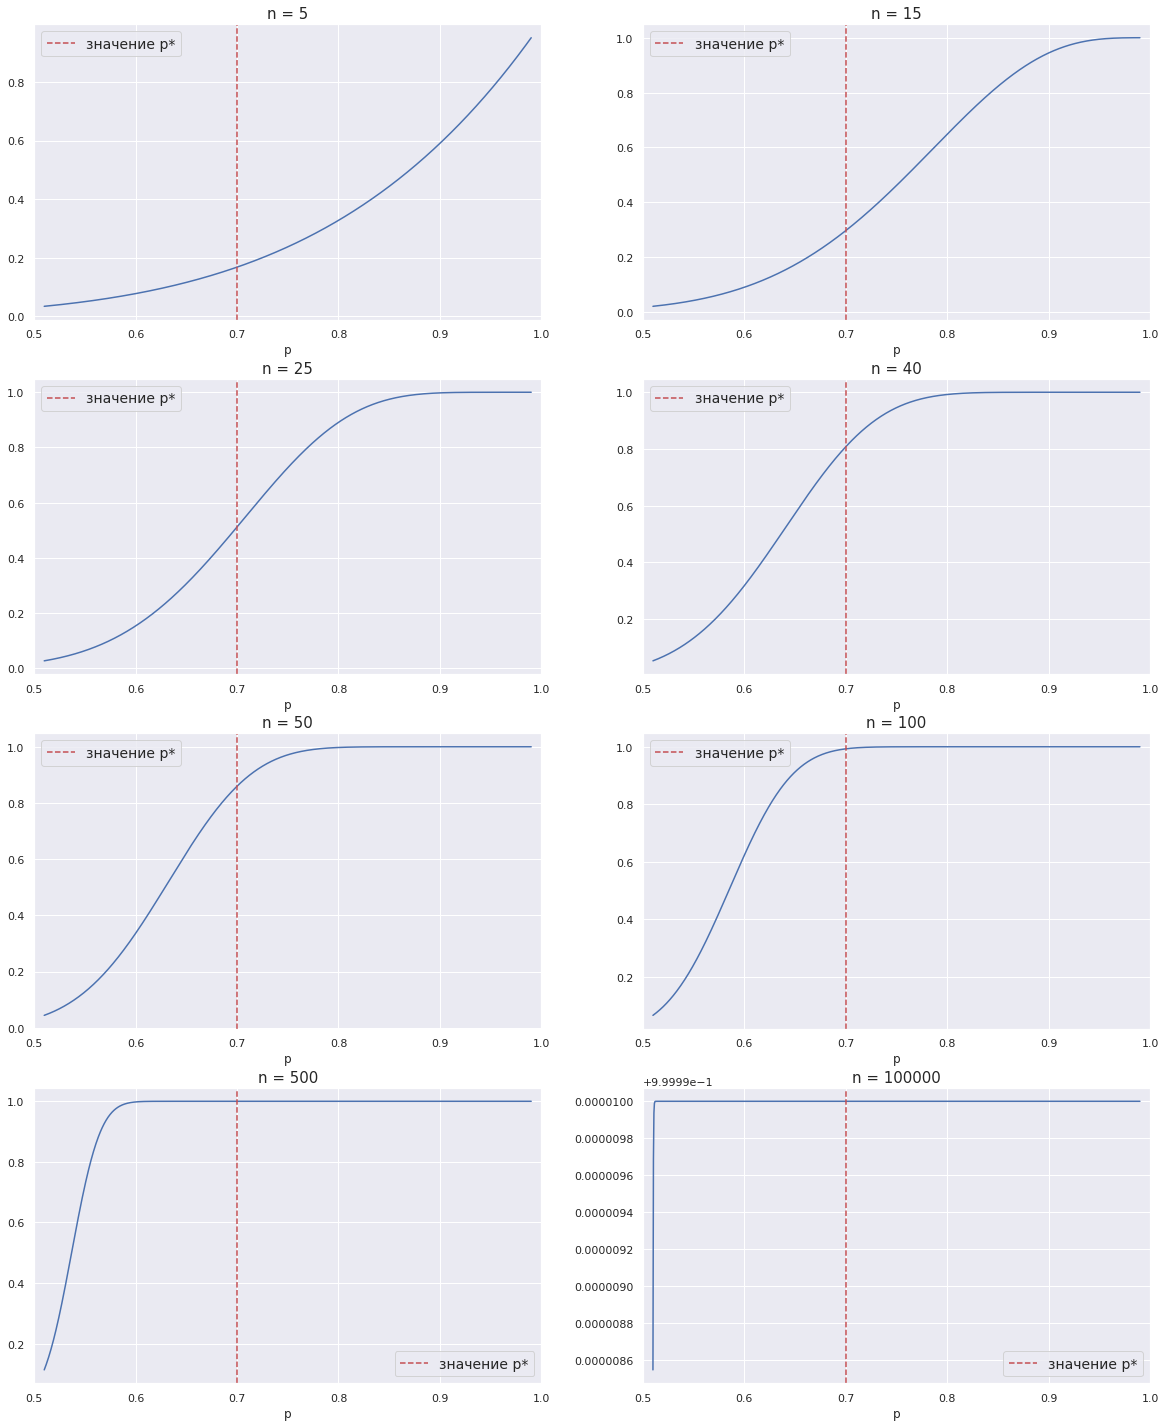

In [261]:
p_thrd = 0.7
alpha = 0.05
ns = [5, 15, 25, 40, 50, 100, 500, 10**5]

plt.figure(figsize = (20, 25))

for i, n in enumerate(ns):
    plt.subplot(4, 2, i+1)
    grid = np.linspace(0.51, 0.99, 1000)

    c = sps.binom(n=n, p=0.5).ppf(1-alpha)

    power = 1 - sps.binom(n=n, p=grid).cdf(c)
    
    plt.title("n = %d" % (n), fontsize=15)
    plt.xlabel("p", fontsize=12)    
    
    plt.xlim((1/2,None))
    plt.plot(grid, power)
    plt.axvline(p_thrd, linestyle='--', c='r',
                label='значение p*')
    
    plt.legend( fontsize=14)
    
    

plt.show()    

In [260]:
c = sps.binom(n=np.arange(30, 50), p=0.5).ppf(1-alpha)
1 - sps.binom(n=np.arange(30, 50), p=0.7).cdf(c)

array([0.73037039, 0.68790188, 0.64401775, 0.73338179, 0.69316797,
       0.77292538, 0.73651439, 0.80709569, 0.77445184, 0.73971878,
       0.80744825, 0.77618849, 0.83599882, 0.80808733, 0.86059582,
       0.83584182, 0.80895385, 0.85988282, 0.83594621, 0.88062789])

Наиболее подходит $n^* = 40$ - выберем его 

Для выбранного $n^*$ проведите эксперимент, аналогичный проведенным ранее экспериментам, сгенерировав выборки для следующих истинных значений $p$: 1). $1/2 < p < p^*$; 2). $p > p^*$.

In [269]:
n_thrd = 40
ps = [0.85, 0.55]

for p in ps:
    sample = sps.bernoulli(p=p).rvs((10, n_thrd))
    t = sample.sum(axis=1)
    
    p_value = 1 - sps.binom(n=n_thrd, p=0.5).cdf(t)
    reject = p_value <= alpha
    table.append((t, p_value,
                 reject))
    
    table = list(zip(t, p_value, reject))
    print("n = %d, p=%.2f"% (n_thrd, p))
    print(pd.DataFrame(table, columns=["Реализация статистики",
                             "p-value",
                            "Отвергается?"]))
    print("\n--------\n")


n = 40, p=0.85
   Реализация статистики       p-value  Отвергается?
0                     36  9.732503e-09          True
1                     35  9.285122e-08          True
2                     36  9.732503e-09          True
3                     38  3.728928e-11          True
4                     31  9.108291e-05          True
5                     31  9.108291e-05          True
6                     33  4.182292e-06          True
7                     33  4.182292e-06          True
8                     32  2.113851e-05          True
9                     35  9.285122e-08          True

--------

n = 40, p=0.55
   Реализация статистики   p-value  Отвергается?
0                     18  0.682086         False
1                     23  0.134094         False
2                     22  0.214795         False
3                     26  0.019239          True
4                     19  0.562685         False
5                     24  0.076930         False
6                     22  0.21479

**Вывод:**

Для выбранного нами $n^*$ с помощью предварительно выбранного $p^*$ - ситуация выглядит гораздо лучше.
Так - если у нас истинное значение $p$ - больше порогового, то гипотеза почти наверняка отвергается. А если значение $p$ - меньше, (то находится относительно близко  к значению $p= 1/2$), то гипотеза чаще всего не отвергается. То есть теперь благодаря хорошему выбору $n^*$ - ситуация выглядит гораздо правдоподобней и логичней с точки зрения практики.

Мы наблюдали, что во время проверки гипотезы - зачастую нужно быть осторожным с выбором размера выборки, а также то, что наши конечные выводы должны опираться не только на математическую основу, но и на логику, на реальную практическую значимость результата.

__________________
### Задача 8.
В Долгопрудном крупная торговая сеть Y10 имеет $100$ магазинов и планирует открыть еще $5$ магазинов. Сеть Y10 считает магазин успешным, если его дневная выручка в $27$ днях из $30$ превышает некоторый установленный порог. Благодаря модели машинного обучения, обученной на предыдущих $100$ магазинах, было выбрано 5 потенциальных точек, в которых и решено было открыть новые магазины. 

Вам предоставлена чистая выручка по каждому из $5$ магазинов за день в течении трех месяцев ($31 + 30 + 31$ день) работы этих пяти магазинов. Считается, что магазин успешен в течении дня, если его выручка за этот день превышает $50000$ рублей. По этому правилу сопоставьте каждому магазину набор бернуллиевских случайных величин, которе принимают значение $1$, если магазин успешен в течении дня. Для простоты будем считать, что выручка за день не зависит от аналогичных показателей за предыдущие дни, и ее распределение не меняется во времени, то есть данные образуют выборку.

Модель машинного обучения выдает также параметры для априорного бета-распределения распределения по каждому из магазинов:
1. $Beta(1, 1)$;
2. $Beta(2900, 100)$;
3. $Beta(29, 1)$;
4. $Beta(29, 1)$;
5. $Beta(1, 1)$.

Проанализируйте данные и ответьте на следующие вопросы.
1. Для каких из магазинов можно утверждать, что с вероятностью $0.95$ их можно считать успешными? Для ответа на этот вопрос нужно выполнить байесовскую проверку гипотез $\mathsf{H}_0\colon\ p=27/30\ vs.\ \mathsf{H}_1\colon\ p>27/30$, посчитав апостериорную вероятность события $\{p>27/30\}$. Если эта вероятность не меньше $0.95$, магазин можно считать успешным.
2. Про какие из магазинов можно сказать, что их лучше закрыть? Закрывать магазин затратно, для этого он должен быть убыточным в $27$ днях из $30$. Для ответа на этот вопрос нужно выполнить байесовскую проверку гипотез $\mathsf{H}_0\colon\ p=3/30\ vs.\ \mathsf{H}_1\colon\ p<3/30$, посчитав апостериорную вероятность события $\{p<3/30\}$. Если эта вероятность не меньше $0.95$, магазин можно закрыть.
3. Что можно сказать об остальных магазинах?
4. Выполнены ли предположения модели на практике? Имеет ли смысл собирать данные сразу после открытия магазина?

In [6]:
data = pd.read_csv("data/y10.csv", sep='\t')
data = data > 50000

data.head()

,Shop 1,Shop 2,Shop 3,Shop 4,Shop 5
0,True,False,False,False,False
1,True,False,False,False,False
2,True,True,False,True,False
3,True,False,False,False,False
4,True,False,False,True,False


In [7]:
#проверим магазины на успешность
As = [1, 2900, 29, 29, 1]
Bs = [1, 100, 1, 1, 1]
n = 92

for i, (a, b) in enumerate(zip(As, Bs)):
    sample = data["Shop %d" %(i+1)].get_values().astype(int)
    
    S = 1 - sps.beta(a=a+sample.sum(), 
                     b=b + n - sample.sum() ).cdf(27/30)
    
    if (S >= 0.95):
        print("Shop %d - успешный, вероятность (p > 27/30) : %f" %(i + 1, S))
    else:
        print("Shop %d - не успешный, вероятность (p > 27/30) : %f" %(i + 1, S))
    print("--------")    
    

Shop 1 - успешный, вероятность (p > 27/30) : 0.999371
--------
Shop 2 - успешный, вероятность (p > 27/30) : 1.000000
--------
Shop 3 - не успешный, вероятность (p > 27/30) : 0.000000
--------
Shop 4 - не успешный, вероятность (p > 27/30) : 0.000000
--------
Shop 5 - не успешный, вероятность (p > 27/30) : 0.000000
--------


In [10]:
#проверим магазины на затратность 

for i, (a, b) in enumerate(zip(As, Bs)):
    sample = data["Shop %d" %(i+1)].get_values().astype(int)
    
    S = sps.beta(a=a+sample.sum(), 
                     b=b + n - sample.sum() ).cdf(3/30)
    
    if (S >= 0.95):
        print("Shop %d - затратный, вероятность (p < 3/30) - %f" %(i + 1, S))
    else:
        print("Shop %d - не затратный, вероятность (p < 3/30) - %f" %(i + 1, S))
    print("--------") 

Shop 1 - не затратный, вероятность (p < 3/30) - 0.000000
--------
Shop 2 - не затратный, вероятность (p < 3/30) - 0.000000
--------
Shop 3 - не затратный, вероятность (p < 3/30) - 0.000001
--------
Shop 4 - не затратный, вероятность (p < 3/30) - 0.000000
--------
Shop 5 - затратный, вероятность (p < 3/30) - 0.961839
--------


Мы ничего не сказали о магазине 3 и магазине 4. У них у обоих было априорное распределение $Beta(29, 1)$.
Давайте посмотрим на это распределение:

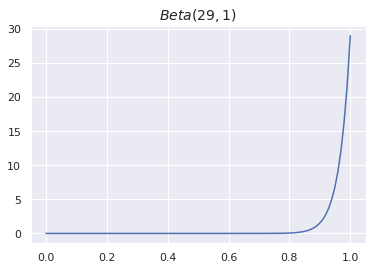

In [308]:
grid=np.linspace(0,1,100)
plt.title(r"$Beta(29,1)$", fontsize=14)
plt.plot(grid, sps.beta(29, 1).pdf(grid))

То есть модель машинного обучения - при подсчете этих параметров выразила сильную уверенность в успешных продажах у этих магазинов.

Теперь давайте посмотрим на апостериорные распределения.

------ Shop 3 ------
кол-во успешных дней :  2
кол-во неуспешных :  90


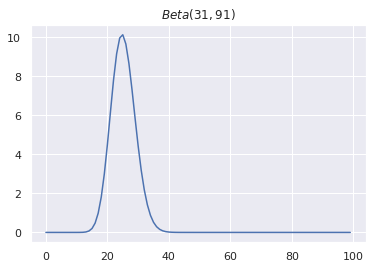

----------------------------------------
------ Shop 4 ------
кол-во успешных дней :  36
кол-во неуспешных :  56


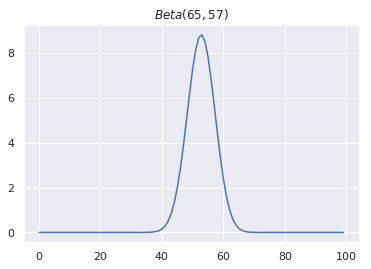

----------------------------------------


In [306]:
shops = ["Shop 3", "Shop 4"] 

for shop in shops:
    print("------ " + shop + " ------")
    sample = data[shop].get_values().astype(int)
    print("кол-во успешных дней : ", sample.sum())
    print("кол-во неуспешных : ", 92-sample.sum())
    
    new_a = 29+sample.sum()
    new_b = 1 + 92 - sample.sum()
    plt.title(r"$Beta(%d, %d)$" % (new_a, new_b))
    plt.plot(sps.beta(a=new_a, b=new_b ).pdf(grid))
    plt.show()
    print("----------------------------------------")

У обоих магазинов апостериорное распределение получилось больше смещенное к середине, чем к какому-либо краю. А так как пик у этих распределений довольно высок и разброс относительно пика очень маленький, поэтому у краев вероятность практически нулевая. Поэтому ничего не получается сказать - о прибыльности или убыточности этих мест.

In [325]:
def experiments(shop, a, b):
    print("------ " + shop + " ------")
    sample = data[shop].get_values().astype(int)
    print("кол-во успешных дней : ", sample.sum())
    print("кол-во неуспешных : ", 92-sample.sum())
    
    new_a = a+sample.sum()
    new_b = b + 92 - sample.sum()
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.title(r"Априорное : $Beta(%d, %d)$" % (a, b),
             fontsize=14)
    plt.plot(grid, sps.beta(a=a, b=b ).pdf(grid))
    
    
    plt.subplot(1,2,2)
    plt.title(r"Апостериорное : $Beta(%d, %d)$" % (new_a, new_b),
             fontsize=14)
    plt.plot(grid, sps.beta(a=new_a, b=new_b ).pdf(grid))
    plt.show()
    print("----------------------------------------")

**Рассмотрим, действительно ли предположения модели соответствуют наблюдениям. **

------ Shop 1 ------
кол-во успешных дней :  91
кол-во неуспешных :  1


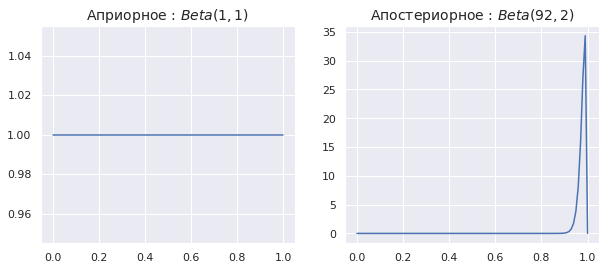

----------------------------------------


In [326]:
experiments("Shop 1", 1, 1)

В 1ом магазине модели видимо ничего не было известно об априоном распределении прибыльности за день, поэтому оставила априорное как равномерное на $[0, 1]$. В итоге, судя по выборке, оказалось, что магазин прибыльный, поэтому апостериорное и получилось таким.

------ Shop 2 ------
кол-во успешных дней :  31
кол-во неуспешных :  61


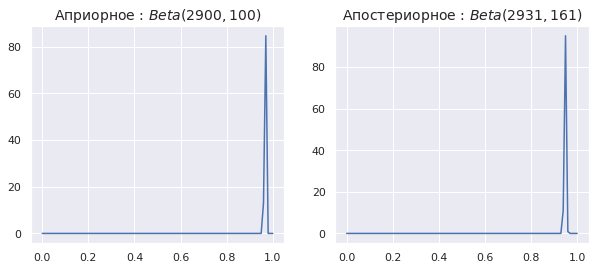

----------------------------------------


In [327]:
experiments("Shop 2", 2900, 100)

Для второго магазина модель выразила очень большую уверенность в том, что прибыльность будет очень высокой - примерно один неуспешный день к 30 успешным. Но на практике оказалось, что успешных дней в половину меньше, чем плохих дней. Но благодаря "излишней уверенности в успехе" размера выборки не хватило, чтобы не только придти к соответствующему парктике результату, но даже отдалить пик распределения от 1. Поэтому мы совершенно неправильно (исходя из данных) посчитали магазин успешным.

------ Shop 3 ------
кол-во успешных дней :  2
кол-во неуспешных :  90


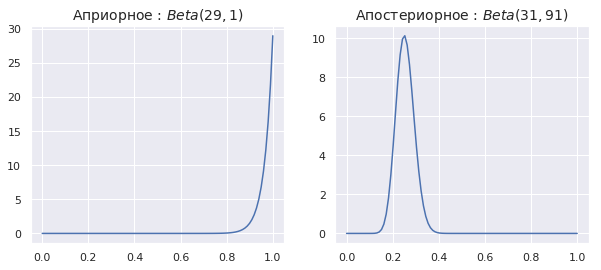

----------------------------------------


In [328]:
experiments("Shop 3", 29, 1)

В 3ем магазине ситуация похожа на 2ой магазин, только немного лучше. Модель также выразила уверенность, что прибыльность будет 1 плохой день к 30ти прибыльным, только сказала об этом не так уверенно как в предыдущем пункте. Мы видим, что в третьем магазине данные совершенно не соответствуют априорному распределению - всего лишь 2 успешных дня. Судя по данным вероятность успешного дня этого магазина должна быть очень мала, и апостериорному распределению видимо не хватило размера выборки, чтобы "уйти" вплотную к левому краю, но зато пик распределения все-таки теперь смещен ближе к 0 чем к 1, в отличие от 2ого магазина.

Поэтому, хоть и начальное предположение модели не соответствует выборке, но апостериорное распределение, хоть все еще плохо описывает данные, но показывает перевес в сторону неуспешных дней, что уже неплохо. 

------ Shop 4 ------
кол-во успешных дней :  36
кол-во неуспешных :  56


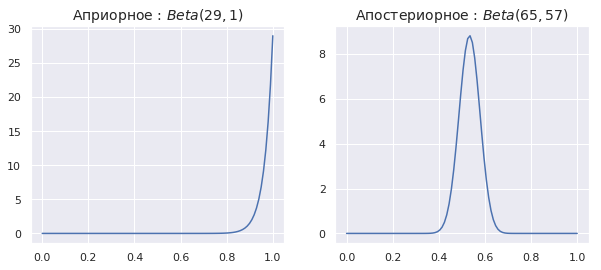

----------------------------------------


In [329]:
experiments("Shop 4", 29, 1)

Здесь ситуация похожа на предыдущие два, только здесь априорное распределение уже больше соответсвтует данным. Опять же, параметры априорного распределения плохо соответсвует практике, но апостериорное распределение получилось довольно разумное - оно не относит магазин ни к успешным, ни к затратным.

------ Shop 5 ------
кол-во успешных дней :  4
кол-во неуспешных :  88


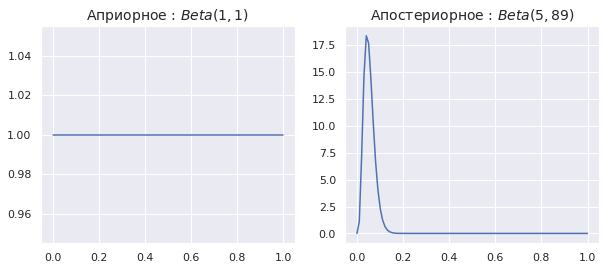

----------------------------------------


In [330]:
experiments("Shop 5", 1, 1)

Здесь модель, как и в 1ом магазине, не делала никаких предположений относительно доли успешных дней. В результате кол-во неуспешных получилось гораздо больше чем успешных, поэтому апостериорное распределение получилось сильно близким к нулю, и магазин закономерно был признан затратным. 

Вообще говоря, данные не стоит собирать сразу после открытия магазина, потому что они, вполне вероятно, не будут соответствовать дальнейшим данным. Например, о магазине сразу после открытия еще может не знать большая часть потенциальных покупателей, которая затем о нем узнает. Или, наоборот, была большая рекламная кампания по открытию этого магазина, и в первые дни туда ходило очень много людей, но затем магазин не оправдает ожидания части населения и его прибыльность снизится.

**Вывод:**

Нужно быть осторожней с выбором параметров априорного распределения и не выражать слишком большой уверенности в результате, так как если выбрать неправильные априорные параметры, которые к тому же выражают довольно экстремальное распределение (например близкое к какому-либо краю с высоким пиком), то  размера реальных данных может не хватить, чтобы "исправить" апостериорное распределение на более правдивое. В итоге получаем результаты, не соответствующие реальности.

Также хотелось бы отметить, что в байесовском подходе при больших данных, зачастую получается очень маленький разброс апостериорного распределения, что не всегда хорошо, так как получается, что вероятность значения параметра, по логике не сильно отличающегося от например Матожа апостериорного распределения, будет почти нулевой, что может не соответствовать реальной ситуации.